# Nucleus Detection

Nucleus detection is an important way to quantify tissue morphology. `PathML` aims to provide tools for nucleus segmentation using several approaches. This notebook walks through a relatively simple nucleus detection algorithm - as more advanced methods are incorporated into `PathML` they will be added here.

In [1]:
import matplotlib.pyplot as plt

from pathml.preprocessing.wsi import HESlide
from pathml.preprocessing.transforms_HandE import BasicNucleusDetectionHE, StainNormalizationHE
from pathml.preprocessing.transforms import SuperpixelInterpolationSLIC, BinaryThreshold
from pathml.preprocessing.utils import plot_mask

**OpenSlide Data**  
This example notebook uses publicly available images from OpenSlide. Download them [here](http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/) if you want to run this notebook locally, or change the filepaths to any whole-slide images that you have locally.

In [2]:
testslide = HESlide("../data/CMU-1-Small-Region.svs")
testdata = testslide.load_data(location = (900, 800), size = (500, 500))

## Basic Nucleus Detection

This algorithm from Hu et al. (2018) has three core steps:

1. Isolate the hematoxylin channel of the input image using stain deconvolution (e.g. Vahadane et al. 2016)
2. Perform local interpolation using superpixels (e.g. SLIC superpixels, Achanta et al. 2012)
3. Use binary thresholding to segment nuclei (e.g. Otsu's method, Otsu 1979)

Here we show each step individually:

In [3]:
# initialize stain separator
stain_separator = StainNormalizationHE(target = "hematoxylin", stain_estimation_method = "vahadane")
# apply stain separator to pull out hematoxylin channel
hematoxylin = stain_separator.apply(testdata.image)
# perform superpixel interpolation
interpolated = SuperpixelInterpolationSLIC().apply(hematoxylin)
# Use Otsu's method for binary thresholding
segmented = BinaryThreshold(use_otsu=True).apply(interpolated)

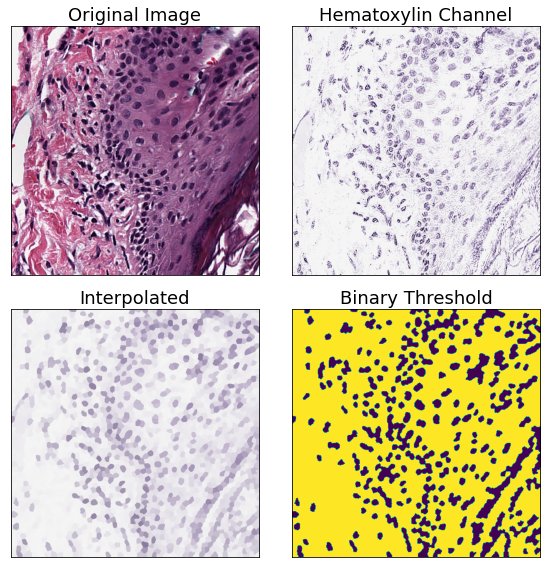

In [4]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

ims = [testdata.image, hematoxylin, interpolated, segmented]
titles = ["Original Image", "Hematoxylin Channel", 'Interpolated', "Binary Threshold"]

for ax, im, title in zip(axarr.ravel(), ims, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize = 18)
    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()

We provide `BasicNucleusDetectionHE()` which implements the above algorithm, allowing you to segment nuclei in one line of code:

In [5]:
segmented = BasicNucleusDetectionHE().apply(testdata.image)

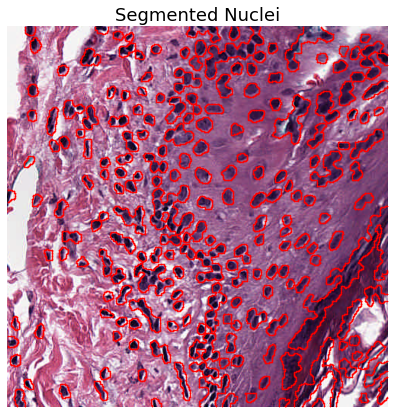

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_mask(im = testdata.image, mask_in=segmented, ax=ax)
plt.title("Segmented Nuclei", fontsize = 18)
plt.axis('off')
plt.show()

## References

* Achanta, R., Shaji, A., Smith, K., Lucchi, A., Fua, P. and Süsstrunk, S., 2012. SLIC superpixels compared to state-of-the-art superpixel methods. IEEE transactions on pattern analysis and machine intelligence, 34(11), pp.2274-2282.
* Hu, B., Tang, Y., Eric, I., Chang, C., Fan, Y., Lai, M. and Xu, Y., 2018. Unsupervised learning for cell-level visual representation in histopathology images with generative adversarial networks. IEEE journal of biomedical and health informatics, 23(3), pp.1316-1328.
* Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and cybernetics, 9(1), pp.62-66.
* Vahadane, A., Peng, T., Sethi, A., Albarqouni, S., Wang, L., Baust, M., Steiger, K., Schlitter, A.M., Esposito, I. and Navab, N., 2016. Structure-preserving color normalization and sparse stain separation for histological images. IEEE transactions on medical imaging, 35(8), pp.1962-1971.